In [ ]:
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
from os import listdir
from random import randint
from sklearn.model_selection import train_test_split
from time import time
from copy import deepcopy
from torch import nn
import os

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_images(dir_to_imgs):
    images = []
    for file in listdir(dir_to_imgs):
      image = imread(os.path.join(dir_to_imgs, file))
      image = resize(image, output_shape=(128, 128))
      image = rgb2gray(image)  
                                                
      images.append(image)
                
    return np.array(images)

In [ ]:
images = load_images("/content/drive/MyDrive/APS360_Project/Dataset/t_image")

In [ ]:
len(images)

647

In [ ]:
def load_masks(dir_to_masks):
    masks = []
    for file in listdir(dir_to_masks):
      mask = imread(os.path.join(dir_to_masks, file))
      mask = resize(mask, output_shape=(128, 128))
      mask = rgb2gray(mask)   

      masks.append(mask)

                
    return  np.array(masks)

In [ ]:
masks = load_masks("/content/drive/MyDrive/APS360_Project/Dataset/t_masked")

In [ ]:
# numones = 0
# numz = 0
# total = 0
# for i in range(len(masks[1])):
#   for j in range(len(masks[1][i])):
#     if(masks[1][i][j] == 1):
#       numones +=1 
#     elif(masks[1][i][j] == 0):
#       numz +=1 
#     # else:
#       # print(masks[1][i][j])
#     total += 1
#   print(max(masks[1][i]))

    
# print(numones)
# print(numz)
# print(total)
# print(numones + numz)

In [ ]:
# 1081 + 14868

augmentation

In [ ]:
def flip(images, labels, axis):
    flipped_images = np.flip(images, axis)
    flipped_labels = np.flip(labels, axis)
    return flipped_images, flipped_labels

def augmentation(images, labels):
    # Data augmentation (flip_horizontal)
    flipped_y_images, flipped_y_labels = flip(images, labels, axis=2)

    # Concatenate arrays
    images = np.concatenate([images, flipped_y_images])
    labels = np.concatenate([labels, flipped_y_labels])

    # Data augmentation (flip_vertical)
    flipped_x_images, flipped_x_labels = flip(images, labels, axis=1)

    # Concatenate arrays
    images = np.concatenate([images, flipped_x_images])
    labels = np.concatenate([labels, flipped_x_labels])


    return images, labels

images, masks = augmentation(images, masks)
print(f"Images shape: {images.shape}",
      f"Masks shape: {masks.shape}\n")

Images shape: (2588, 128, 128) Masks shape: (2588, 128, 128)



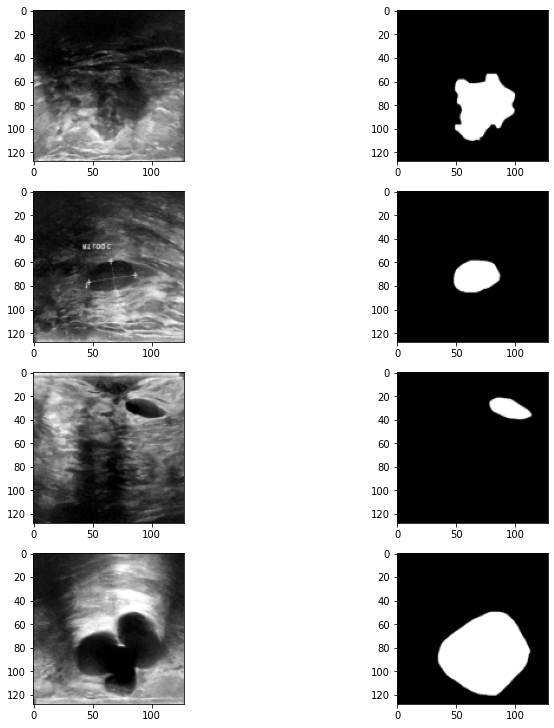

In [ ]:
f, axis = plt.subplots(nrows=4, ncols=2, constrained_layout=True, figsize=(10, 10))
for i in range(4):
    rand = randint(0, images.shape[0]-1)
    axis[i, 0].imshow(images[rand], cmap="gray")
    axis[i, 1].imshow(masks[rand], cmap="gray")
plt.show()

In [ ]:
images = np.expand_dims(images, axis=3)
masks = np.expand_dims(masks, axis=3)


x_train, x_val, y_train, y_val = train_test_split(images, masks,
                                                  test_size= 0.1,
                                                  shuffle=True,
                                                  random_state=2021)

x_test, x_val, y_test, y_val = train_test_split(x_val, y_val,
                                                test_size=0.5,
                                                shuffle=True,
                                                random_state=2021)

print(f"Train arrays shape: {x_train.shape}, {y_train.shape}")
print(f"Test arrays shape: {x_test.shape}, {y_test.shape}")
print(f"Validation arrays shape: {x_val.shape}, {y_val.shape}")

Train arrays shape: (2329, 128, 128, 1), (2329, 128, 128, 1)
Test arrays shape: (129, 128, 128, 1), (129, 128, 128, 1)
Validation arrays shape: (130, 128, 128, 1), (130, 128, 128, 1)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images_format = torch.float32
masks_format = torch.float32

# Free memory
del images, masks

# Convert Numpy arrays to Torch tensors
train_inputs = torch.from_numpy(x_train).to(images_format).to(device)
train_outputs = torch.from_numpy(y_train).to(masks_format).to(device)
del x_train, y_train

val_inputs = torch.from_numpy(x_val).to(images_format).to(device)
val_outputs = torch.from_numpy(y_val).to(masks_format).to(device)
del x_val, y_val

test_inputs = torch.from_numpy(x_test).to(images_format).to(device)
test_outputs = torch.from_numpy(y_test).to(masks_format).to(device)
del x_test, y_test

train_inputs = train_inputs.permute(0, 3, 1, 2)
val_inputs = val_inputs.permute(0, 3, 1, 2)
test_inputs = test_inputs.permute(0, 3, 1, 2)

train_outputs = train_outputs.permute(0, 3, 1, 2)
val_outputs = val_outputs.permute(0, 3, 1, 2)
test_outputs = test_outputs.permute(0, 3, 1, 2)


# Verify datasets shapes
print(f"Train tensor shape: {train_inputs.shape}, {train_outputs.shape}")
print(f"Test tensor shape: {test_inputs.shape}, {test_outputs.shape}")
print(f"Validation tensor shape: {val_inputs.shape}, {val_outputs.shape}")

Train tensor shape: torch.Size([2329, 1, 128, 128]), torch.Size([2329, 1, 128, 128])
Test tensor shape: torch.Size([129, 1, 128, 128]), torch.Size([129, 1, 128, 128])
Validation tensor shape: torch.Size([130, 1, 128, 128]), torch.Size([130, 1, 128, 128])


In [ ]:
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.up_scale = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)

    def forward(self, x1, x2):
        x2 = self.up_scale(x2)

        diffY = x1.size()[2] - x2.size()[2]
        diffX = x1.size()[3] - x2.size()[3]

        x2 = F.pad(x2, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return x


class down_layer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down_layer, self).__init__()
        self.pool = nn.AvgPool2d(2, stride=2, padding=0)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(self.pool(x))
        return x


class up_layer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_layer, self).__init__()
        self.up = up(in_ch, out_ch)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        a = self.up(x1, x2)
        x = self.conv(a)
        return x


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.conv1 = double_conv(1, 8)
        self.down1 = down_layer(8, 16)
        self.down2 = down_layer(16, 32)
        self.down3 = down_layer(32, 64)
        self.down4 = down_layer(64, 128)
        self.down5 = down_layer(128, 256)
        self.down6 = down_layer(256, 512)
        self.down7 = down_layer(512, 1024)
        
        self.up1 = up_layer(1024, 512)
        self.up2 = up_layer(512, 256)
        self.up3 = up_layer(256, 128)
        self.up4 = up_layer(128, 64)
        self.up5 = up_layer(64, 32)
        self.up6 = up_layer(32, 16)
        self.up7 = up_layer(16, 8)
        self.last_conv = nn.Conv2d(8, 1, 1)
        self.dilute = nn.Conv2d(1, 1, 1)


    def forward(self, x):
        x1 = self.conv1(x)
        #print(x1.shape)
        x2 = self.down1(x1)
        #print(x2.shape)

        x3 = self.down2(x2)
        #print(x3.shape)
        x4 = self.down3(x3)
        #print(x4.shape)
        x5 = self.down4(x4)
        #print(x5.shape)
        x6 = self.down5(x5)
        #print(x6.shape)
        x7 = self.down6(x6)
       # print(x7.shape)
        x8 = self.down7(x7)
        #print(x8.shape)
        
        x1_up = self.up1(x7, x8)
       # print(x1_up.shape)
        x2_up = self.up2(x6, x1_up)
        #print(x2_up.shape)
        x3_up = self.up3(x5, x2_up)
        #print(x3_up.shape)
        x4_up = self.up4(x4, x3_up)
        #print(x4_up.shape)
        x5_up = self.up5(x3, x4_up)
        #print(x5_up.shape)
        x6_up = self.up6(x2, x5_up)
        #print(x6_up.shape) 
        x7_up = self.up7(x1, x6_up)
        #print(x7_up.shape)
    
        output = self.last_conv(x7_up)
        output = self.dilute(output)
        output = torch.sigmoid(output)
        return output

In [ ]:
z = torch.randn(1,1,128,128)
m = UNet()
m.eval()
m(z)


tensor([[[[0.5995, 0.5997, 0.5999,  ..., 0.6003, 0.6005, 0.6005],
          [0.5997, 0.5999, 0.6011,  ..., 0.6005, 0.6007, 0.6010],
          [0.5997, 0.5997, 0.6003,  ..., 0.6002, 0.6007, 0.6009],
          ...,
          [0.5999, 0.6001, 0.5999,  ..., 0.6007, 0.6000, 0.6010],
          [0.5998, 0.6004, 0.6007,  ..., 0.6003, 0.6012, 0.6001],
          [0.6006, 0.6008, 0.6012,  ..., 0.6010, 0.6007, 0.6012]]]],
       grad_fn=<SigmoidBackward0>)

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):    
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

    
net = UNet().to(device)
optim = torch.optim.Adam(net.parameters(), lr=1.0E-3)
criterion = DiceLoss()

In [ ]:
best_loss = np.inf
epochs = 200
patience = 5
batch_size = 20
train_losses = []
val_losses = []
achieved_epochs = []
total_train = train_inputs.size()[0]
total_val = val_inputs.size()[0]
print("Begin Training:\n")

t0 = time()
for epoch in range(epochs):
    net.train()
    train_loss = 0
    val_loss = 0
    achieved_epochs.append(epoch)
    train_permutation = torch.randperm(total_train)
    val_permutation = torch.randperm(total_val)

    for i in range(0, total_train, batch_size):
        optim.zero_grad()
        indices = train_permutation[i:i+batch_size]
        batch_x, batch_y = train_inputs[indices], train_outputs[indices]
        outputs = net(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optim.step()
        train_loss += loss
    train_loss = train_loss.cpu().detach() /(total_train/batch_size) #total_train
    train_losses.append(train_loss)

    for j in range(0, total_val, batch_size):
        net.eval()
        indices = val_permutation[j:j+batch_size]
        batch_x, batch_y = val_inputs[indices], val_outputs[indices]
        outputs = net(batch_x)
        loss = criterion(outputs, batch_y)
        
        val_loss += loss
    val_loss = val_loss.cpu().detach() / (total_val / batch_size)#total_val
    val_losses.append(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        cost_patience = patience
        state_dict = deepcopy(net.state_dict())
        print(f"\tEpoch: {epoch+1}/{epochs}, ",
              f"Train Loss: {train_loss:.3g}, ",
              f"Val Loss: {val_loss:.3g}")

    else:
        cost_patience -= 1
        if cost_patience < 0:
            print(f"\nEarly stopping after {patience} epochs of no improvements")
            break

        else:
            print(f"\tEpoch: {epoch+1}/{epochs}, ",
                  f"Train Loss: {train_loss:.3g}, ",
                  f"Val Loss: {val_loss:.3g} - No improvement",
                  f"-> Remaining patience: {cost_patience}")

tf = time()
print(f"\nTrain finished successfully in {tf-t0:.3g}s")

Train loop:

	Epoch: 1/200,  Train Loss: 0.785,  Val Loss: 0.831
	Epoch: 2/200,  Train Loss: 0.693,  Val Loss: 0.708
	Epoch: 3/200,  Train Loss: 0.517,  Val Loss: 0.494
	Epoch: 4/200,  Train Loss: 0.367,  Val Loss: 0.403
	Epoch: 5/200,  Train Loss: 0.3,  Val Loss: 0.341
	Epoch: 6/200,  Train Loss: 0.287,  Val Loss: 0.328
	Epoch: 7/200,  Train Loss: 0.255,  Val Loss: 0.299
	Epoch: 8/200,  Train Loss: 0.256,  Val Loss: 0.306 - No improvement -> Remaining patience: 4
	Epoch: 9/200,  Train Loss: 0.23,  Val Loss: 0.333 - No improvement -> Remaining patience: 3
	Epoch: 10/200,  Train Loss: 0.23,  Val Loss: 0.296
	Epoch: 11/200,  Train Loss: 0.228,  Val Loss: 0.326 - No improvement -> Remaining patience: 4
	Epoch: 12/200,  Train Loss: 0.216,  Val Loss: 0.261
	Epoch: 13/200,  Train Loss: 0.215,  Val Loss: 0.273 - No improvement -> Remaining patience: 4
	Epoch: 14/200,  Train Loss: 0.217,  Val Loss: 0.289 - No improvement -> Remaining patience: 3
	Epoch: 15/200,  Train Loss: 0.205,  Val Loss: 0

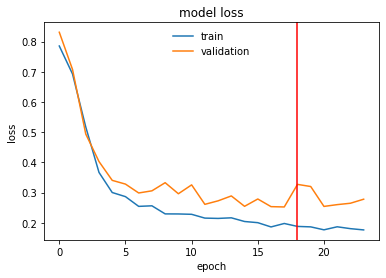

In [ ]:
f, ax = plt.subplots()
ax.plot(achieved_epochs, train_losses, label='train')
ax.plot(achieved_epochs, val_losses, label='validation')
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
no_improvement_line = achieved_epochs[-1] - patience
ax.axvline(x=no_improvement_line, color='r')
ax.legend(loc='upper center', frameon=False)
plt.show()

In [ ]:
torch.save(state_dict, "./checkpoint.pth")
print("\nCheckpoint saved successfully :)")


Checkpoint saved successfully :)


Predictions

In [ ]:
state = torch.load("/content/checkpoint.pth")#"/content/drive/MyDrive/APS360_Project/checkpoint.pth")
net.load_state_dict(state)

<All keys matched successfully>

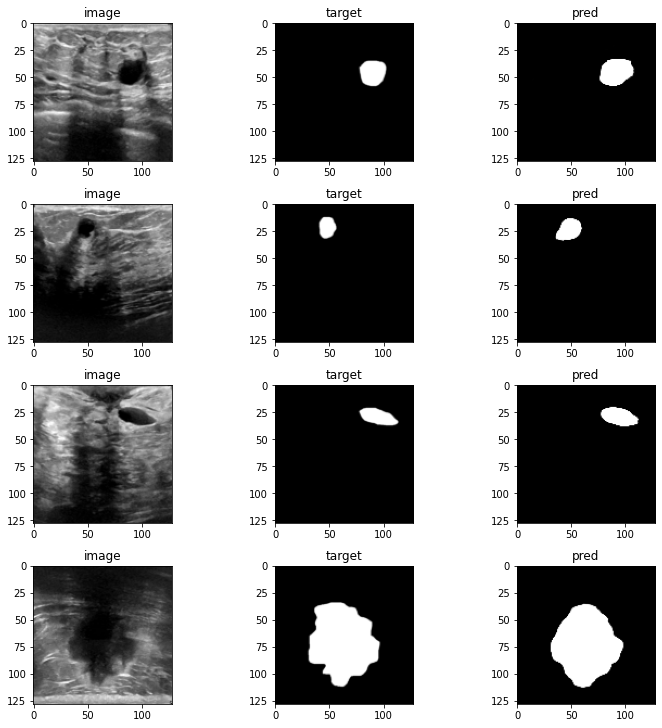

In [ ]:
predictions = net(test_inputs).cpu().detach().numpy()
images = test_inputs.cpu().detach().numpy()
masks = test_outputs.cpu().detach().numpy()

f, axis = plt.subplots(nrows=4, ncols=3, constrained_layout=True, figsize=(10, 10))
for i in range(4):
    rand = randint(0, images.shape[0]-1)
    axis[i, 0].imshow(images[rand][0], cmap="gray")
    axis[i, 0].set_title("image")
    axis[i, 1].imshow(masks[rand][0], cmap="gray")
    axis[i, 1].set_title("target")
    axis[i, 2].imshow(predictions[rand][0], cmap="gray")
    axis[i, 2].set_title("pred")

plt.show()

In [ ]:
print(len(test_outputs))

129


Evaluate model

In [ ]:

running_dice = 0
net.eval()
for i in range(len(test_inputs)):
  curr_inp = test_inputs[i].unsqueeze(dim=0)
  # print(curr_inp.shape)
  pred = net(curr_inp)
  diceloss = criterion(pred, test_outputs[i])
  running_dice += 1-diceloss
print(running_dice/len(test_inputs))

tensor(0.7380, device='cuda:0', grad_fn=<DivBackward0>)


In [ ]:
predictions.shape

(129, 1, 128, 128)

In [ ]:
d = criterion(predictions, test_outputs)

TypeError: ignored

In [ ]:
d


tensor(0.1997, device='cuda:0', grad_fn=<RsubBackward1>)

In [ ]:
1-d

tensor(0.8003, device='cuda:0', grad_fn=<RsubBackward1>)